In [52]:
# Package Imports
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

from shapely.geometry import LineString, Polygon, Point
from shapely.affinity import rotate, scale

import pulp

from spopt.locate import PMedian

from importlib import reload

# to load the interactive plotting version
#%matplotlib widget
# or regular
# %matplotlib inline
# %gui qt
import vispy
%matplotlib qt

# Importing my modules
from src import data_loading, plotting, geometry_operations, optimization_functions, geometry_utilities, classes, cable_road_computation, mechanical_computations

In [53]:
reload(data_loading)
tree_gdf, height_gdf = data_loading.load_processed_gdfs()

In [54]:
reload(mechanical_computations)
# Brute computation of euler knicklast series

list_of_euler_max_force_lists = []
for index,row in tree_gdf.iterrows():
    list = [mechanical_computations.euler_knicklast(bhd, height) for bhd, height in zip(row["diameter_series"], row["height_series"])]
    list_of_euler_max_force_lists.append(list)

tree_gdf["max_supported_force_series"] = list_of_euler_max_force_lists

tree_gdf["max_holding_force"] = (((tree_gdf["BHD"]*0.1)**2)/3)*10000

In [55]:
tree_gdf

,Unnamed: 0.1,Unnamed: 0,x,y,z,id,BHD,h,crownLength,crownArea,crownVolume,crownDiameter,geometry,height_series,diameter_series,max_supported_force_series,max_holding_force
0,0,0,-68.216701,61.395624,-52.341,1.0,56.149714,"38,74","37,64","34,8",87.6,"6,9",POINT (-68.217 61.396),"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[75.3285252060416, 59.2357212453479, 50.810257...","[24959017.529930785, 9543866.365885176, 129162...",105093.013828
1,1,1,-42.198416,22.294888,-26.887,2.0,4.000000,"9,54",0,0,0.0,0,POINT (-42.198 22.295),"[0, 1, 2, 3]","[5.17530099308459, 4.75298477202177, 3.2428768...","[556.0733471775088, 395.59912126499376, 21.431...",533.333333
2,2,2,-35.660549,48.789428,-39.520,3.0,34.565562,"33,07","15,77","20,1",39.2,"5,8",POINT (-35.661 48.789),"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[46.8504987923709, 36.4729261214776, 31.775120...","[3734620.721509984, 1371740.7949710337, 197550...",39825.935649
3,3,3,-63.811228,60.685099,-52.156,4.0,32.057200,"33,07","10,92","19,4",40.0,"5,5",POINT (-63.811 60.685),"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[43.2279489877914, 33.8089756227105, 29.540885...","[2706750.015506462, 1012785.9686439564, 147578...",34255.469061
4,4,4,-12.395044,77.242318,-42.336,5.0,38.388823,"24,77",0,0,0.0,0,POINT (-12.395 77.242),"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[55.7820784857842, 40.5344790286549, 35.891517...","[7505305.874191268, 2092608.616092059, 321585....",49123.391658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628,628,628,4.503100,96.760800,-52.333,640.0,63.800000,"20,51",0,0,0.0,0,POINT (4.503 96.761),"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[87.7883727950596, 67.4612323325051, 57.679290...","[46040244.74440359, 16054866.843714008, 214491...",135681.333333
629,629,629,3.241200,92.597600,-48.579,641.0,10.000000,"28,74",0,0,0.0,0,POINT (3.241 92.598),"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[13.8643107671387, 10.4097357856807, 9.7764999...","[28640.64305018616, 9102.243580090704, 1770.36...",3333.333333
630,630,630,11.452980,27.791890,-9.873,642.0,44.560000,"31,1","25,9","22,1",68.1,"5,8",POINT (11.453 27.792),"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[62.1299186181293, 47.1173202065811, 40.791665...","[11550286.736280661, 3820427.432434701, 536556...",66186.453333
631,631,631,10.763840,30.705970,-11.548,643.0,28.660000,"24,77",0,0,0.0,0,POINT (10.764 30.706),"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[40.8627631729488, 30.2315805390719, 26.979354...","[2161227.820024012, 647489.9610760516, 102672....",27379.853333


#### Joining and Overlaying Anchor Areas and Road on the Map

##### Recording coordinates with interactive figure

In [56]:
# coords = []
# fig, ax = plt.subplots()
# ax.set_xlabel('X coordinate', fontsize=15)
# ax.set_ylabel('Y coordinate', fontsize=15)
# ax.scatter(tree_gdf["x"],tree_gdf["y"])

# cid = fig.canvas.mpl_connect('button_press_event',  lambda event: plotting.onclick(event,coords))

In [57]:
# disconnect the interactive figure so it doesnt eat up resources
# fig.canvas.mpl_disconnect(cid)

##### Creating extra-geometry from manual coordinates

In [58]:
# manually insert those coordinates
# recorded coordinates for the given areas
downhill_anchors = Polygon([Point(xy) for xy in [(-123.88268627035482, 83.05479790035122), (-74.89307684787903, 138.5299549848453), (-21.10056454084676, 161.97821725767267), (-6.051468835903222, 148.2524051955298), (-60.16417466857257, 116.79741921978575), (-115.23746107815322, 64.75371515082742)]])
uphill_anchors = Polygon([Point(xy) for xy in [(-55.04107825837903, -15.31352187833928), (-17.578435758838708, -17.601157222029755), (4.194723984483858, -1.5877098161964227), (30.450593086725803, -30.18315161232738), (-11.49475877173387, -41.04941949485714), (-58.5632070403871, -38.189875315244045)]])
# road = LineString([(-57.282432937838706, -17.029248386107135), (-34.86888614324194, -21.604519073488092), (-15.337081079379033, -15.31352187833928), (-0.2879853744354932, -7.878707011345227), (12.51975565104837, 6.990922722642864), (19.884206740701615, 21.86055245663097)])
# road = LineString([(-59.52378761729838, -12.453977698726185), (-41.91314370725806, -13.597795370571419), (-18.218822810112897, -10.16634235503571), (3.2341434075725886, 0.12801669157144602), (15.401497381782264, 23.576278964398824), (17.00246500996775, 26.43582314401192)])
road = LineString([(-89.6286010742188, -24.4624996185303),(-69.618896484375, -20.364200592041),(-41.314998626709, -13.9251003265381),(-29.2644004821777, -8.47910022735596),(-20.2950000762939, -3.67030000686646),(-15.375, -0.148599997162819),(-6.49030017852783, 2.74860000610352),(0.943400025367737, 3.86450004577637),(15.1605997085571, -0.302300006151199),(29.3377990722656, -3.47709989547729)])

inner_forest = Polygon([Point(xy) for xy in [(-105.43005197808363, 62.73802056488026), (-10.557896233758669, 146.34023494632802), (13.160142702322588, 51.07259530235265), (8.890895693827957, 9.27148811162877), (-55.62217021231302, -10.17088732591722), (-81.71201304200238, 18.992675830401765)]])

extra_geometry_gpd = gpd.GeoDataFrame(pd.DataFrame({"name":["uphill_anchors","road","downhill_anchors","inner_forest"],"geometry":[uphill_anchors,road,downhill_anchors,inner_forest]}))

# set the name as index to easily select the geometry
extra_geometry_gpd.set_index("name", inplace = True)
extra_geometry_gpd.loc['road']

# plotting.plot_gdfs([tree_gdf,extra_geometry_gpd])

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


geometry    LINESTRING (-89.62860 -24.46250, -69.61890 -20...
Name: road, dtype: geometry

#### Generating Eligible Trees and Road Pathway

Getting the points along the road

In [59]:
interval = 2
road_points = geometry_operations.generate_road_points(extra_geometry_gpd.loc['road'].geometry, interval)
# plotting.plot_scatter_xy(road_points)

Getting the trees contained in the anchor/target tree polygons

In [60]:
# get the eligible anchor and target trees inside the polygon
anchor_trees_gdf = geometry_operations.filter_gdf_by_contained_elements(tree_gdf, extra_geometry_gpd.loc["uphill_anchors"].geometry)
target_trees_gdf = geometry_operations.filter_gdf_by_contained_elements(tree_gdf,extra_geometry_gpd.loc["downhill_anchors"].geometry)
inner_forest_gdf = geometry_operations.filter_gdf_by_contained_elements(tree_gdf, extra_geometry_gpd.loc["inner_forest"].geometry)
harvesteable_trees_gdf = pd.concat([target_trees_gdf,inner_forest_gdf])

#filter the anchor and target trees for a BHD of 30cm or larger
anchor_trees_gdf = anchor_trees_gdf[anchor_trees_gdf["BHD"] >= 30]
target_trees_gdf = target_trees_gdf[target_trees_gdf["BHD"] >= 30]

# and check if the anchor trees look good
plotting.plot_scatter_xy(harvesteable_trees_gdf.geometry)

#### Generating Possible Lines

##### Setting and rotating the slope line

In [61]:
slope_degree = 29

# set a orientation line we can plan the line deviation around
slope_line = LineString([(0,0),(0,1)])
slope_line = rotate(slope_line, slope_degree)

# scale the line by a factor of 100 and plot it
slope_line = scale(slope_line,100,100)

# ax = plotting.plot_equal_axis(slope_line)
# ax.scatter(bestand_3_csv["x"], bestand_3_csv["y"])

##### Generating the possible lines depending on the slope

In [62]:
%load_ext line_profiler

In [76]:
plt.close("all")

In [78]:
reload(geometry_operations)
reload(geometry_utilities)
reload(plotting)
reload(classes)
reload(cable_road_computation)
reload(mechanical_computations)
plot_possible_lines = False

# expression for debugging
# %lprun -T tmp0.txt -f classes.Cable_Road.compute_line_height line_gdf, start_point_dict = cable_road_computation.generate_possible_lines(road_points, target_trees_gdf_filtered_diameter, anchor_trees_gdf_filtered_diameter, tree_gdf, slope_line, height_gdf, plot_possible_lines)
line_gdf, start_point_dict = cable_road_computation.generate_possible_lines(road_points, target_trees_gdf, anchor_trees_gdf, tree_gdf, slope_line, height_gdf, plot_possible_lines)
print("we have n lines: ",len(line_gdf))

# unpack to geopandas
buffer = gpd.GeoSeries(line_gdf["line_candidates"].values)
new_line_gdf = gpd.GeoDataFrame(geometry=buffer)
new_line_gdf[line_gdf.columns] = line_gdf[line_gdf.columns].values
new_line_gdf["line_length"] = new_line_gdf.geometry.length
line_gdf = new_line_gdf

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


2304  candidates initially
2278  after slope deviations
1388  after supports trees
75  after possible anchor triples
Cable road created from line:  (-29.880646898378075, -8.757599103801436) to  (-106.0132132, 89.40781657)
Tension to begin with is 85000.0
checking if tower and anchor trees hold
force on anchor 68999.99999999991 force on twoer 233386.52266435776 max supported force by anchor 50455.810418596404
force on anchor 67999.99999999991 force on twoer 231812.38808653358 max supported force by anchor 33683.37211407743
force on anchor 67999.99999999991 force on twoer 232250.4148714178 max supported force by anchor 85243.58538663962
did not find anchor tree that holds - final
Tower and anchors hold: False
checking if tower and anchor trees hold
force on anchor 59999.999999999935 force on twoer 205112.0415779062 max supported force by anchor 50455.810418596404
force on anchor 58999.99999999994 force on twoer 203638.08243160445 max supported force by anchor 33683.37211407743
force on a

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/src/mechanical_computations.py:726: RuntimeWarning: invalid value encountered in double_scalars
  """
/home/carlo/GitHub/MultiObjectOptimizationCableYarding/src/geometry_utilities.py:103: RuntimeWarning: invalid value encountered in divide
  d = np.divide(b - a, np.linalg.norm(b - a))


computing tension loaded vs unloaded cable road
Angle: 109.33296914434975
Angle is too big, testing
Force on loaded cable: 73421.94870126402
force on tree anchor support  73421.94870126402
vs support tree max supp force 1.0513566497580025
Cable road created from line:  (-64.22261696, 99.88663092) to  (-66.22582216, 101.0207349)
computing tension loaded vs unloaded cable road
Angle: 109.57555412001322
Angle is too big, testing
Force on loaded cable: 73531.97182084977
force on tree anchor support  73531.97182084977
vs support tree max supp force 0.5783050457451184
Cable road created from line:  (-64.22261696, 99.88663092) to  (-67.28799379, 101.654708)
computing tension loaded vs unloaded cable road
Angle: 104.98937326566696
Angle is too big, testing
Force on loaded cable: 71396.7194638236
force on tree anchor support  71396.7194638236
vs support tree max supp force 0.036663761729009474
Cable road created from line:  (-64.22261696, 99.88663092) to  (-64.29244843, 101.1682476)
computing t

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/src/mechanical_computations.py:726: RuntimeWarning: invalid value encountered in double_scalars
  """
/home/carlo/GitHub/MultiObjectOptimizationCableYarding/src/geometry_utilities.py:103: RuntimeWarning: invalid value encountered in divide
  d = np.divide(b - a, np.linalg.norm(b - a))


computing tension loaded vs unloaded cable road
Angle: 109.5755508201867
Angle is too big, testing
Force on loaded cable: 57191.532476144384
force on tree anchor support  57191.532476144384
vs support tree max supp force 0.5783050457451184
Cable road created from line:  (-64.22261696, 99.88663092) to  (-67.28799379, 101.654708)
computing tension loaded vs unloaded cable road
Angle: 104.98934738554654
Angle is too big, testing
Force on loaded cable: 55530.7721799603
force on tree anchor support  55530.7721799603
vs support tree max supp force 0.036663761729009474
Cable road created from line:  (-64.22261696, 99.88663092) to  (-64.29244843, 101.1682476)
computing tension loaded vs unloaded cable road
Angle: 113.36825458037364
Angle is too big, testing
Force on loaded cable: 58495.8663051945
force on tree anchor support  58495.8663051945
vs support tree max supp force 0.001337407291860934
Cable road created from line:  (-64.22261696, 99.88663092) to  (-64.88103345, 100.2676934)
computing 

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/src/mechanical_computations.py:726: RuntimeWarning: invalid value encountered in double_scalars
  """
/home/carlo/GitHub/MultiObjectOptimizationCableYarding/src/geometry_utilities.py:103: RuntimeWarning: invalid value encountered in divide
  d = np.divide(b - a, np.linalg.norm(b - a))


force on anchor 21000.0 force on twoer 92953.25104373525 max supported force by anchor 58488.91749495594
found anchor tree that holds
Tower and anchors hold: True
checking if supports hold
Cable road created from line:  (-64.22261696, 99.88663092) to  (-65.91435043, 101.5545211)
computing tension loaded vs unloaded cable road
Angle: 109.33295736959009
Angle is too big, testing
Force on loaded cable: 40789.9685293859
force on tree anchor support  40789.9685293859
vs support tree max supp force 1.0513566497580025
Cable road created from line:  (-64.22261696, 99.88663092) to  (-66.22582216, 101.0207349)
computing tension loaded vs unloaded cable road
Angle: 109.57554488051017
Angle is too big, testing
Force on loaded cable: 40851.09313144146
force on tree anchor support  40851.09313144146
vs support tree max supp force 0.5783050457451184
Cable road created from line:  (-64.22261696, 99.88663092) to  (-67.28799379, 101.654708)
computing tension loaded vs unloaded cable road
Angle: 104.9893

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/src/mechanical_computations.py:726: RuntimeWarning: invalid value encountered in double_scalars
  """
/home/carlo/GitHub/MultiObjectOptimizationCableYarding/src/geometry_utilities.py:103: RuntimeWarning: invalid value encountered in divide
  d = np.divide(b - a, np.linalg.norm(b - a))


Tension to begin with is 85000.0
checking if tower and anchor trees hold
force on anchor 73999.99999999988 force on twoer 259549.1545029343 max supported force by anchor 54142.47444834902
force on anchor 73999.9999999999 force on twoer 258896.53093703956 max supported force by anchor 40398.26654467902
force on anchor 74999.9999999999 force on twoer 261368.0419448028 max supported force by anchor 40921.26952260097
did not find anchor tree that holds - final
Tower and anchors hold: False
checking if tower and anchor trees hold
force on anchor 64999.999999999935 force on twoer 226486.55254072134 max supported force by anchor 54142.47444834902
force on anchor 64999.999999999935 force on twoer 225913.30211121924 max supported force by anchor 40398.26654467902
force on anchor 65999.99999999993 force on twoer 228197.41662947636 max supported force by anchor 40921.26952260097
did not find anchor tree that holds - final
Tower and anchors hold: False
checking if tower and anchor trees hold
force

In [67]:
reload(plotting)
plotting.plot_gdf_with_anchors_and_supports([target_trees_gdf,anchor_trees_gdf, inner_forest_gdf, extra_geometry_gpd], line_gdf)

In [73]:
line_gdf

,geometry,line_candidates,slope_deviation,tree_anchor_support_trees,possible_anchor_triples,max_holding_force,number_of_supports,location_of_int_supports,current_tension,angle_between_supports,line_length
0,"LINESTRING (-22.810 -5.019, -107.911 82.709)",LINESTRING (-22.809794172088516 -5.01856654142...,15.129383,Unnamed: 0.1 Unnamed: 0 x ...,"[(LINESTRING (-4.352596 -25.27437571, -22.8097...","[54142.47444834902, 40921.26952260097, 39010.8...",1,[POINT (-77.894284 52.61685171)],55000,29.300161,122.222644
1,"LINESTRING (-19.363 -3.003, -83.375 106.991)",LINESTRING (-19.362655444150658 -3.00293454972...,1.197837,Unnamed: 0.1 Unnamed: 0 x ...,"[(LINESTRING (-4.352596 -25.27437571, -19.3626...","[54142.47444834902, 40398.26654467902, 39010.8...",1,[POINT (-69.79732 85.42912)],55000,31.527542,127.265056
2,"LINESTRING (-17.736 -1.839, -106.013 89.408)",LINESTRING (-17.736348462948033 -1.83883592722...,15.052265,Unnamed: 0.1 Unnamed: 0 x ...,"[(LINESTRING (5.750624681 -23.50333184, -17.73...","[58488.91749495594, 77791.40260660947, 30065.0...",0,[],65000,29.466205,126.959665
3,"LINESTRING (-17.736 -1.839, -72.969 113.723)",LINESTRING (-17.736348462948033 -1.83883592722...,3.454535,Unnamed: 0.1 Unnamed: 0 x ...,"[(LINESTRING (-4.352596 -25.27437571, -17.7363...","[54142.47444834902, 40398.26654467902, 39010.8...",1,[POINT (-51.51983649 66.06245366)],55000,31.483172,128.082628
4,"LINESTRING (-16.110 -0.675, -67.582 122.305)",LINESTRING (-16.110041481745412 -0.67473730473...,6.288464,Unnamed: 0.1 Unnamed: 0 x ...,"[(LINESTRING (-4.352596 -25.27437571, -16.1100...","[54142.47444834902, 40398.26654467902, 39010.8...",1,[POINT (-52.68046227 84.56854314)],55000,31.347963,133.316601


In [74]:
line_gdf_full = line_gdf.copy()

In [75]:
%store line_gdf_full

Stored 'line_gdf_full' (GeoDataFrame)


#### Optimization Setup

In [68]:
# reload(geometry_operations)
reload(optimization_functions)

# Apply the Line Cost Function:
uphill_yarding = 1
large_yarder = 0
intermediate_support_height = 12 #take the average for now
line_gdf["line_cost"] = [optimization_functions.line_cost_function(line_gdf["line_length"][index], uphill_yarding, large_yarder,intermediate_support_height,line_gdf["number_of_supports"][index]) for index in range(len(line_gdf))]

# Create a matrix with the distance between every tree and line and the distance between the support (beginning of the CR) and the carriage (cloests point on the CR to the tree)
distance_tree_line, distance_carriage_support = geometry_operations.compute_distances_facilities_clients(harvesteable_trees_gdf, line_gdf)

# sort the facility (=lines) and demand points (=trees)
facility_points_gdf = line_gdf.reset_index()
demand_points_gdf = harvesteable_trees_gdf.reset_index()

# set up the solver
solver = pulp.PULP_CBC_CMD(msg=False, warmStart=True)
name = "model"

# create the nr of possible facilities and clients 
client_range = range(distance_tree_line.shape[0])
facility_range = range(distance_tree_line.shape[1])

# add facility cost with an optional scaling factor
facility_scaling_factor = 0.1

facility_cost = line_gdf.line_cost.values*facility_scaling_factor

# create the aij cost matrix, which is really just the distance from the tree to the line
aij = distance_tree_line

# collect the matrices needed for the optimization
tree_volumes_list = harvesteable_trees_gdf["crownVolume"]
angle_between_supports_list = line_gdf["angle_between_supports"]
# cost_distance_tree_line
# distance_carriage_support

average_steepness = geometry_operations.compute_average_terrain_steepness(line_gdf, height_gdf)

# and the productivity cost combination of each line combination
productivity_cost = optimization_functions.calculate_productivity_cost(client_range, facility_range, aij, distance_carriage_support, average_steepness)

#### SpOPT

Creating our custom problem with constraints

- Obj Func v4:
	- ```sum(harvest_time * cli_assgn_vars[cli][fac])```
		- minimize the overall harvest time between clients and the factory they are assigned too
		- ```harvest_time = yarding_distance+lateral_yarding_distance+tree_volume+harvest_intensity+slope```
	- ```sum(fac_vars[fac]*fac_cost[fac] for fac in facility_range])```
		- minimize the sum of factory costs

- Matrices:
	- Lineactiveindex = fac_vars = $[l1+l2...]$
	- linetreeactiveindex = cli_assgn_vars = $[[l1*cli1+l1*cli2...],[l2*cli1+l2*cli2+....]]$

	- fac_cost: the cost of each line
	- cli_demand: mocked variable as of now, can be changed to reflect profit of given tree

- Constraints:
	- Constraint 1:
		- Each client is only assigned to one factory: ```pulp.lpSum([cli_assgn_vars[cli][fac] for fac in facility_range]) == 1```

	- Constraint 2: 
		- Every factory that has a client assigned must be opened: ```lscp.problem += fac_vars[fac] - cli_assgn_vars[cli][fac] >= 0```



In [69]:
# c = [model_list[0].cli_assgn_vars[cli][fac].value() for cli in client_range for fac in facility_range]
# plt.scatter(c, np.arange(len(c)))
reload(optimization_functions)

def optimize_cable_roads(name, aij, facility_range, client_range, facility_cost, start_point_dict, productivity_cost, step, steps):
    # init the model with name and the problem - this only gives it a name and tells it to minimize the obj function
    problem = pulp.LpProblem(name, pulp.LpMinimize)
    model = PMedian(name, problem, aij)

    # Add the facilities as fac_vars and facility_clients as cli_assgn_vars
    optimization_functions.add_facility_variables(model, facility_range)
    optimization_functions.add_facility_client_variables(model, facility_range, client_range)

    # Add the objective functions
    optimization_functions.add_moo_objective_function(model, facility_range, client_range, facility_cost, start_point_dict, productivity_cost, step, steps)

    # Assignment/demand constraint - each client should 
    # only be assigned to one factory
    optimization_functions.add_singular_assignment_constraint(model, facility_range, client_range)

    # Add opening/shipping constraint - each factory that has a client assigned to it should also be opened
    optimization_functions.add_facility_is_opened_constraint(model, facility_range, client_range)

    model = model.solve(solver)
    return model

In [70]:
model_list = []
steps = 3

# iterate combinations of 0.1 steps for a MOO tradeoff
for i in range(steps):
    model = optimize_cable_roads(name, aij, facility_range, client_range, facility_cost, start_point_dict, productivity_cost, i, steps)
    model_list.append(model)


In [78]:
reload(plotting)
for i in range(steps):
    plotting.plot_p_median_results(model_list[i], facility_points_gdf, demand_points_gdf, anchor_trees_gdf, target_trees_gdf, line_gdf)

In [23]:
# visualize optimization outcome, using matplotlib.pyplot
plt.figure(figsize=(15,8))

obj_1_list = [i for i in range(steps)]

# Value of objective function
obj_2_list = [model_list[i].problem.objective.value() for i in range(steps)]

obj_difference = [obj_2_list[i+1]-obj_2_list[i] for i in range(steps-1)]
obj_difference.append(0)

plt.plot(obj_1_list,obj_2_list, color="red")

plt.xlabel("Objective Tradeoff",size=20)
plt.ylabel("Objective Function Value",size=20)
# -- add plot title
plt.title("Combined Objective Function Value",size=32)
# -- show plot
plt.show()

#### PyMOO Testing

In [54]:
import moo_optimization_functions

In [56]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize

#import moo_optimization_functions
reload(moo_optimization_functions)

cost_matrix = aij
problem = moo_optimization_functions.SupportLinesProblem(cost_matrix, facility_cost)
termination = get_termination("n_gen", 7)

reload(optimization_functions)

client_range = cost_matrix.shape[0]
facility_range = cost_matrix.shape[1]

algorithm = NSGA2(
    population=100,
    sampling=IntegerRandomSampling(),
    mutation=moo_optimization_functions.MyMutation(),
    repair=moo_optimization_functions.MyRepair(),
)

res = minimize(problem,
               algorithm,
               termination,
               verbose=True,
               return_least_infeasible=True,
               seed=2)

X = res.X
F = res.F

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      8 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      200 |     14 |  0.000000E+00 |  0.000000E+00 |  0.3124098432 |         ideal
     3 |      300 |     16 |  0.000000E+00 |  0.000000E+00 |  0.2928140407 |         ideal
     4 |      400 |     28 |  0.000000E+00 |  0.000000E+00 |  0.1129085448 |         ideal
     5 |      500 |     39 |  0.000000E+00 |  0.000000E+00 |  0.0542389790 |         ideal
     6 |      600 |     40 |  0.000000E+00 |  0.000000E+00 |  0.1437597508 |         nadir
     7 |      700 |     49 |  0.000000E+00 |  0.000000E+00 |  0.0062614292 |             f


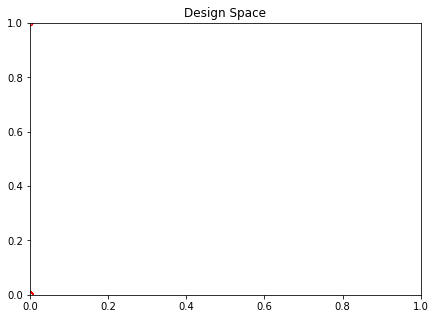

In [57]:
import matplotlib.pyplot as plt
xl, xu = problem.bounds()
plt.figure(figsize=(7, 5))
plt.scatter(X[:, 0], X[:, 1], s=30, facecolors='none', edgecolors='r')
plt.xlim(xl[0], xu[0])
plt.ylim(xl[1], xu[1])
plt.title("Design Space")
plt.show()

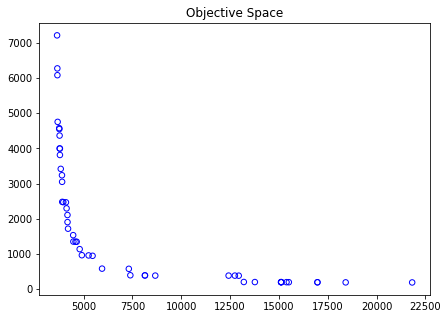

In [58]:
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.show()

In [60]:
x_sol = X[-10]

# Debugging
variable_matrix = x_sol.reshape((len(demand_points_gdf)+1,len(line_gdf)))

cli_assgn_vars = variable_matrix[:-1]
fac_vars = variable_matrix[-1]

#fac_vars
print(cli_assgn_vars[1:5])
#print(np.sum(cli_assgn_vars, axis=1))
print(fac_vars)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0]


In [1]:
import chart_studio.plotly as py

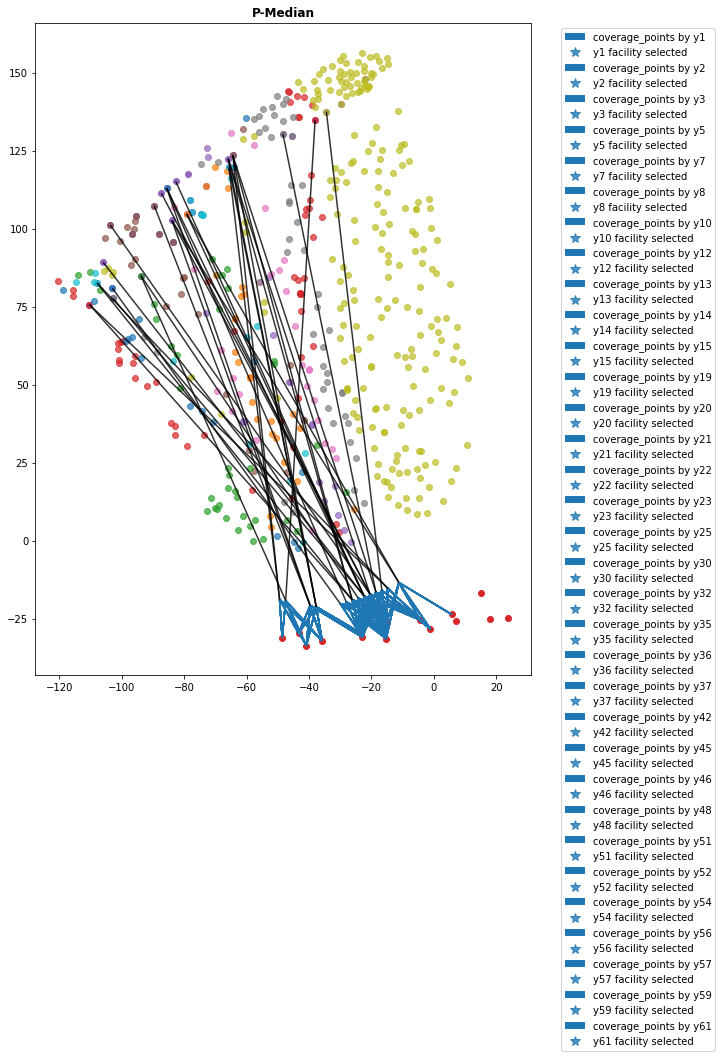

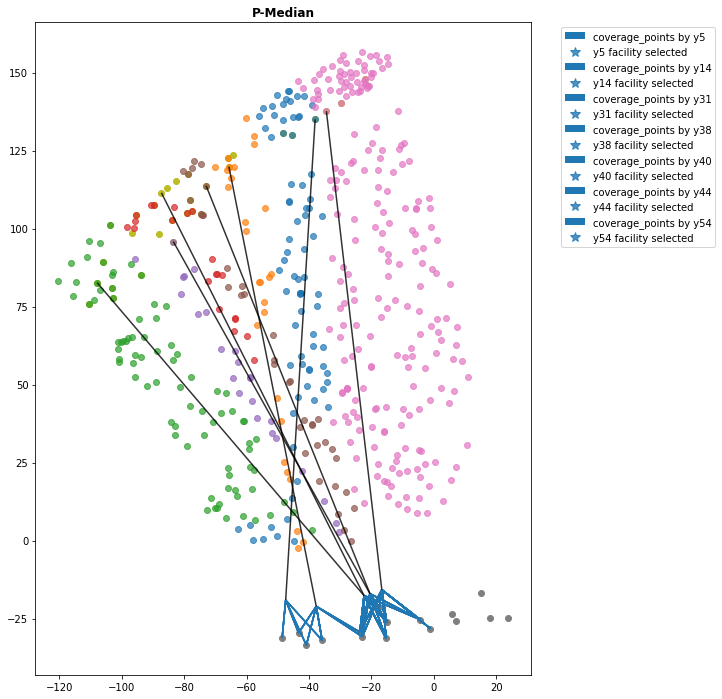

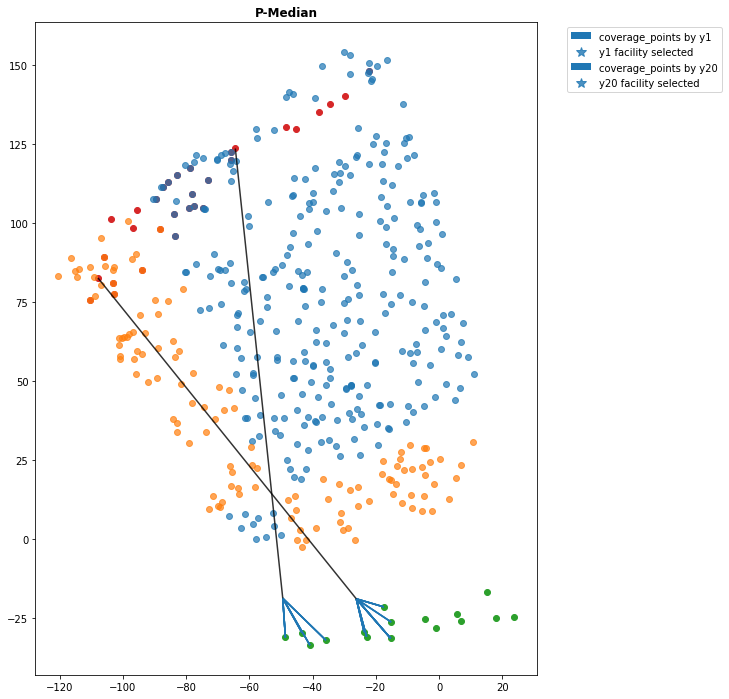

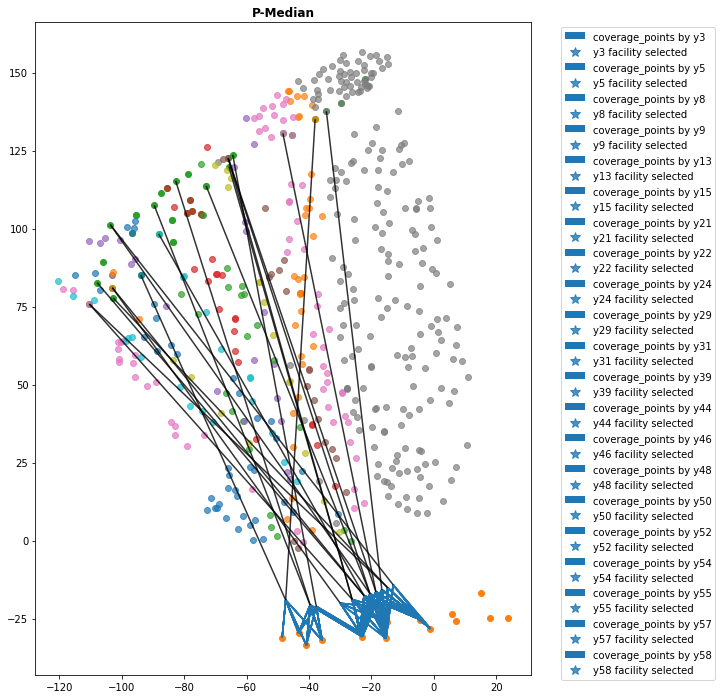

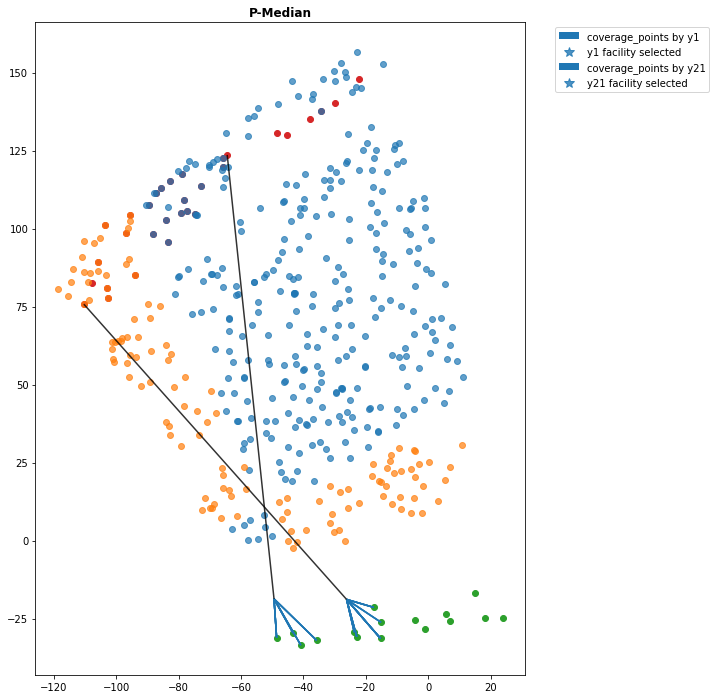

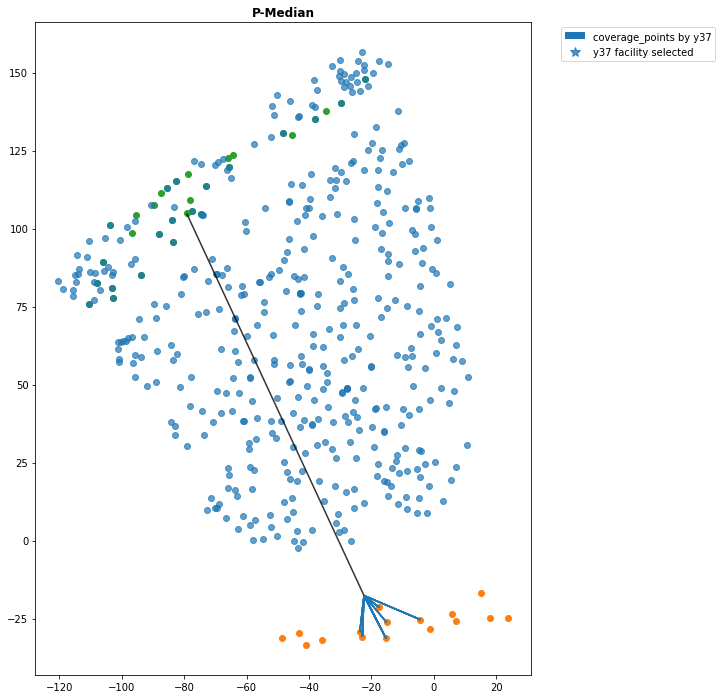

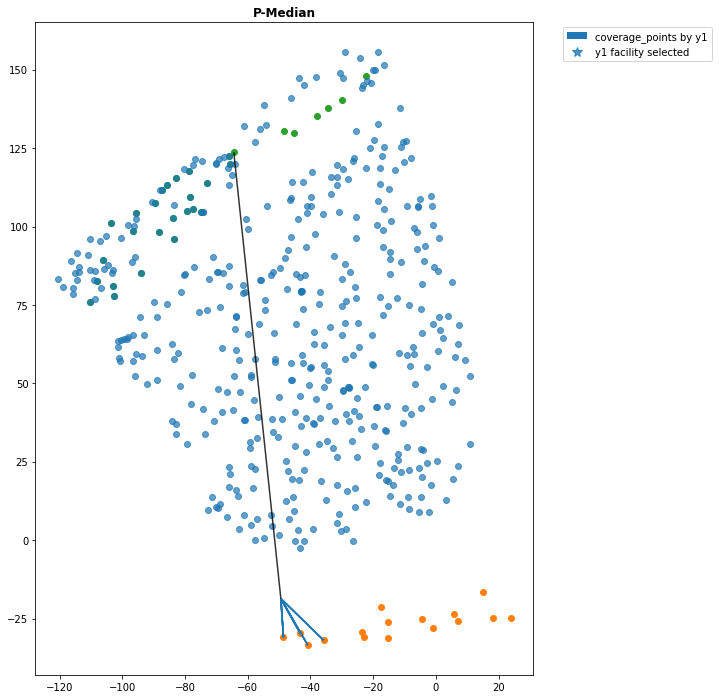

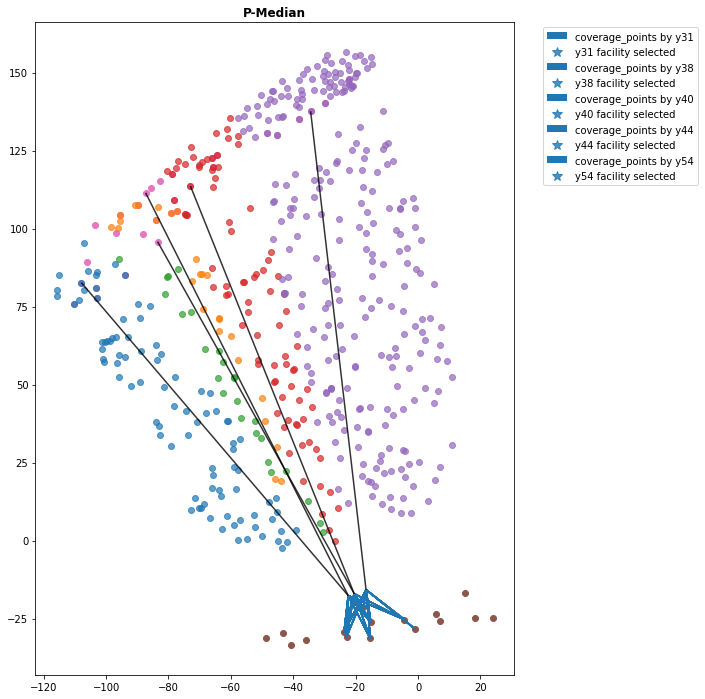

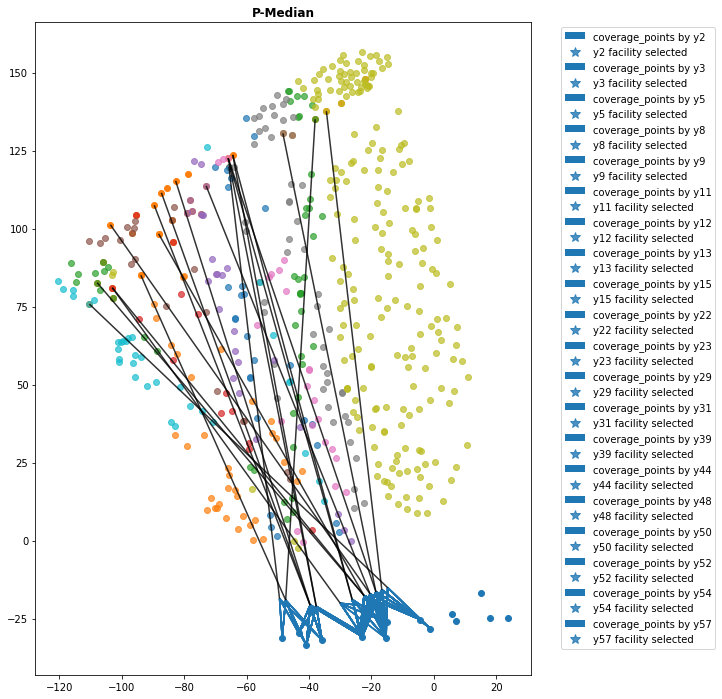

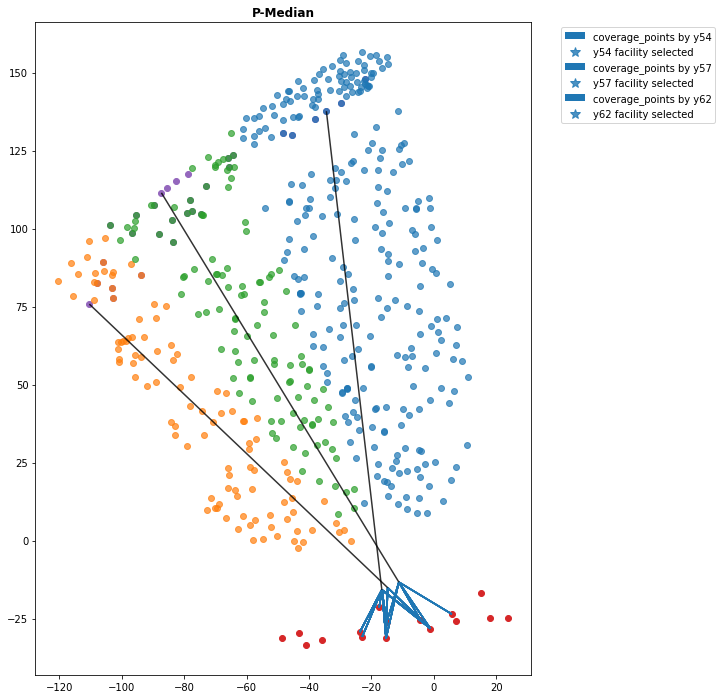

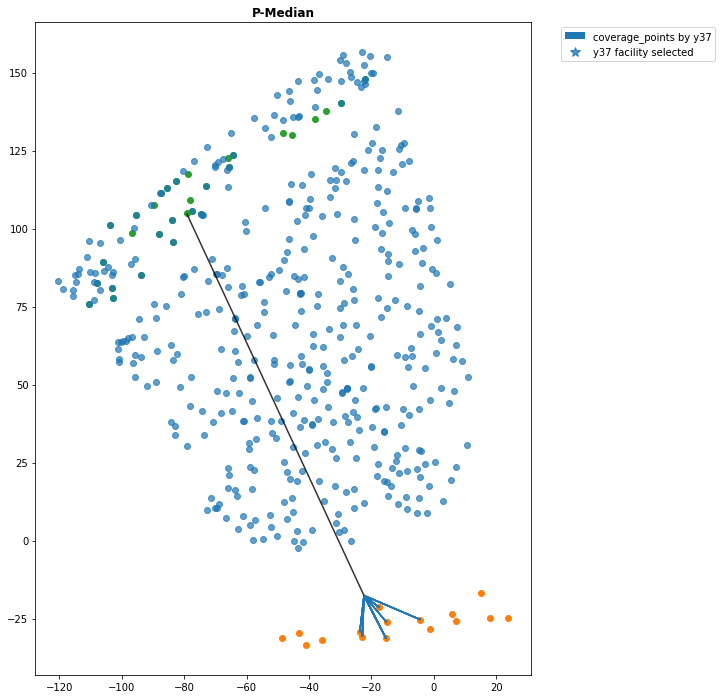

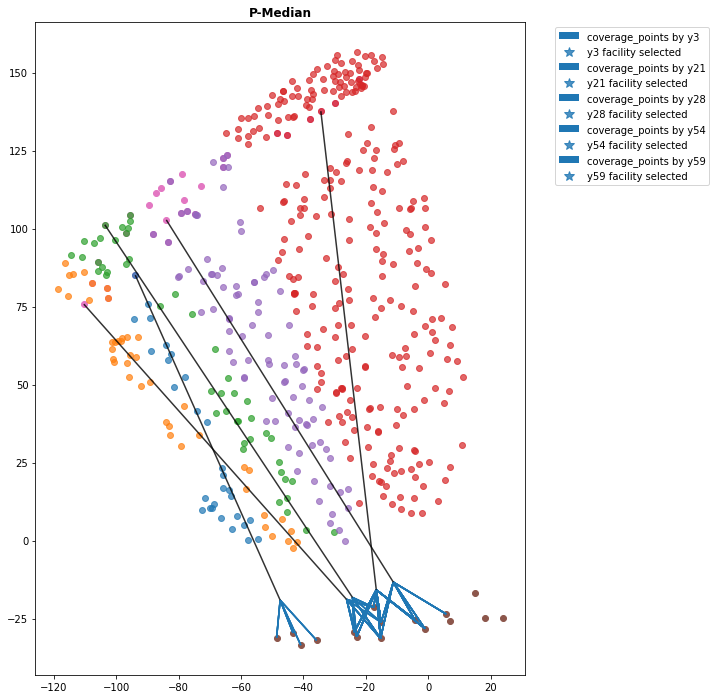

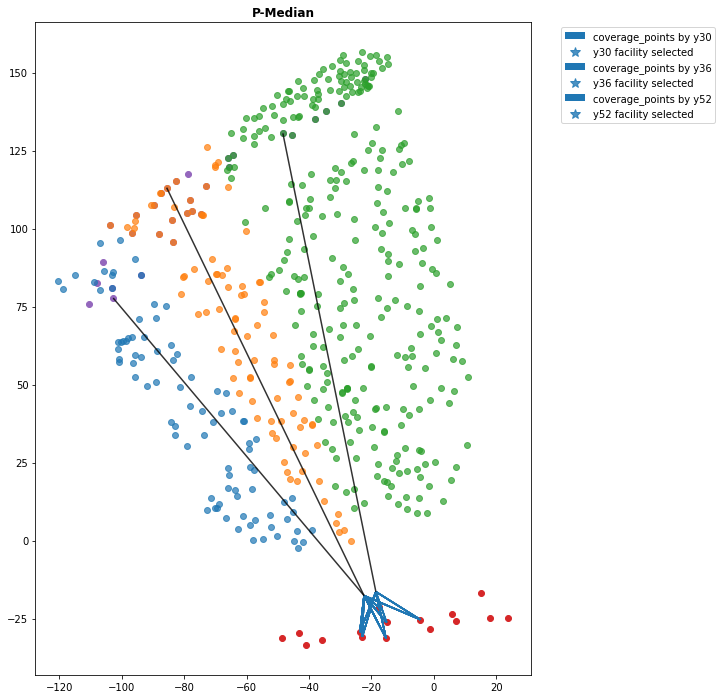

In [61]:
# Visualizations
client_range = cost_matrix.shape[0]
facility_range = cost_matrix.shape[1]
cli_assgn_vars = variable_matrix[:-1]
fac_vars = variable_matrix[-1:]

reload(plotting)

for x_sol in range(0,X.shape[0],4):
    plotting.plot_pymoo_results(X[x_sol], facility_points_gdf, demand_points_gdf, anchor_trees_gdf_filtered_diameter, target_trees_gdf_filtered_diameter, line_gdf)

In [22]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(8,5)})

# for x_sol in range(0,X.shape[0],4):
#     plotting.plot_pymoo_results(X[x_sol], facility_points_gdf, demand_points_gdf, anchor_trees_gdf_filtered_diameter, target_trees_gdf_filtered_diameter, line_gdf)

def plot_explain(i):
    plotting.plot_pymoo_results(X[int(i)], facility_points_gdf, demand_points_gdf, anchor_trees_gdf_filtered_diameter, target_trees_gdf_filtered_diameter, line_gdf)

%matplotlib inline

import numpy as np

interact(plot_explain, i = widgets.FloatSlider(value=1, min=1, max=X.shape[0], step=1))

interactive(children=(FloatSlider(value=1.0, description='i', max=51.0, min=1.0, step=1.0), Output()), _dom_cl…

<function __main__.plot_explain(i)>

In [33]:
range(0,X.shape[0],4)

range(0, 77, 4)